# Steps to Convert from .ts to ListDataset format


## Step 1: Convert .ts to pd.DataFrame

`Gluon-ts` uses a dataset format called `ListDataset`. `ListDataset` is list of dict that has 3 categories of data: the required ones, the optional ones, and the one that can be added by the Transformation. Among the keys, `target` and `start` are required fields. `start` stands for a list of timepoints, useful when date is specified. If the data does not come with a specific date, a default value can be used. `target` is the data coresponding to `start`.

In a univariate setting, suppose where there are n instances of the series and each univariate timeseries has t timepoints, this would yield a DataList with n list, each list having t data points. In practice, this could be used to represent nested DataFrame. Each DataList's list will be one row of the DataFrame. The ListDataset's list can also accomodate multivariate .ts files.

In [156]:
import warnings
warnings.filterwarnings('ignore')

from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas



In [157]:
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]


["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

The simplest way to convert a .ts to ListDataset is by going through pd.Dataframe

In [158]:
import os

import sktime
from sktime.datasets import load_from_tsfile_to_dataframe
import pandas as pd

DATA_PATH = os.path.join(os.path.dirname(sktime.__file__), "datasets/data")

train_x, train_y = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, "ItalyPowerDemand/ItalyPowerDemand_TRAIN.ts")
)
test_x, test_y = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, "ItalyPowerDemand/ItalyPowerDemand_TEST.ts")
)

In [159]:
train_x.head()

,dim_0
0,0 -0.710518 1 -1.183320 2 -1.372442 3...
1,0 -0.993009 1 -1.426786 2 -1.579884 3...
2,0 1.319067 1 0.569774 2 0.195128 3...
3,0 -0.812444 1 -1.157553 2 -1.416385 3...
4,0 -0.972840 1 -1.390518 2 -1.536705 3...


In [160]:
train_x.tail()

,dim_0
62,0 -1.037930 1 -1.301658 2 -1.469485 3...
63,0 -0.373579 1 -0.986632 2 -1.446422 3...
64,0 -1.159152 1 -1.301400 2 -1.524933 3...
65,0 -0.694919 1 -1.235829 2 -1.416133 3...
66,0 0.984033 1 0.169661 2 -0.519423 3...


## Step 2: Convert Pd.DataFrame to DataList

ItalyPowerDemand is a categorical dataset, so `feat_static_cat` is needed. Thus,  we will include `start`, `target` and `feat_static_cat` in the dataset. For train data

In [161]:
import numpy as np

def create_dataset(data, label):
    list_len = len([num for sublist in pd.Series(data.loc[0]) for num in sublist])
    nested_target = np.empty([1,list_len])
    
    for x in range(len(data)):
        flat_list = np.expand_dims(np.array([num for sublist in pd.Series(data.loc[x]) for num in sublist]), axis=0)
        nested_target = np.append(nested_target, flat_list, axis=0)
        #nested_target.append(flat_list)
    nested_target = np.delete(nested_target,0,0)

    # create categorical static feats: pass in train_y
    feat_static_cat = label

    return nested_target, feat_static_cat

In [162]:
# define the parameters of the dataset
custom_ds_metadata = {
    'freq': '1H',
    'start': [
        pd.Timestamp("04-18-2022", freq='1H')  # Arbitrary default date
        for _ in range(len(train_x))
    ]
}

In [163]:
train_data_out = create_dataset(train_x, train_y)

nested_target, feat_static_cat = train_data_out

In [164]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fsc) in zip(
            nested_target,
            custom_ds_metadata['start'],
            feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

In [165]:
train_entry = next(iter(train_ds))
train_entry.keys()


dict_keys(['target', 'start', 'feat_static_cat', 'source'])

In [166]:
ListDataset_check = train_entry["target"]
ListDataset_check

array([-0.7105176 , -1.1833204 , -1.3724416 , -1.5930829 , -1.4670022 ,
       -1.3724416 , -1.0887599 ,  0.04596695,  0.92853224,  1.0861332 ,
        1.2752542 ,  0.96005243,  0.61333036,  0.01444676, -0.6474772 ,
       -0.26923493, -0.20619456,  0.61333036,  1.3698149 ,  1.4643754 ,
        1.054613  ,  0.5818102 ,  0.1720477 , -0.26923493], dtype=float32)

In [167]:
# First row of train_x 
ts_check = np.array([num for sublist in pd.Series(train_x.loc[0]) for num in sublist])
ts_check

array([-0.71051757, -1.1833204 , -1.3724416 , -1.5930829 , -1.4670021 ,
       -1.3724416 , -1.0887599 ,  0.04596695,  0.92853223,  1.0861332 ,
        1.2752543 ,  0.96005242,  0.61333034,  0.01444676, -0.6474772 ,
       -0.26923494, -0.20619456,  0.61333034,  1.3698149 ,  1.4643754 ,
        1.054613  ,  0.58181015,  0.1720477 , -0.26923494])

Check if data are the same after conversion

In [168]:
from numpy.testing import assert_allclose
assert_allclose(ListDataset_check, ts_check)

For test dataset, the same procedure is carried out

In [169]:
# define the parameters of the dataset
custom_ds_metadata = {
    'freq': '1H',
    'start': [
        pd.Timestamp("04-18-2022", freq='1H')  # Arbitrary default date
        for _ in range(len(test_x))
    ]
}

In [170]:
test_data_out = create_dataset(test_x, test_y)

nested_target, feat_static_cat = test_data_out

In [171]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fsc) in zip(
            nested_target,
            custom_ds_metadata['start'],
            feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

In [172]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_static_cat', 'source'])

Plot the dataset we just made

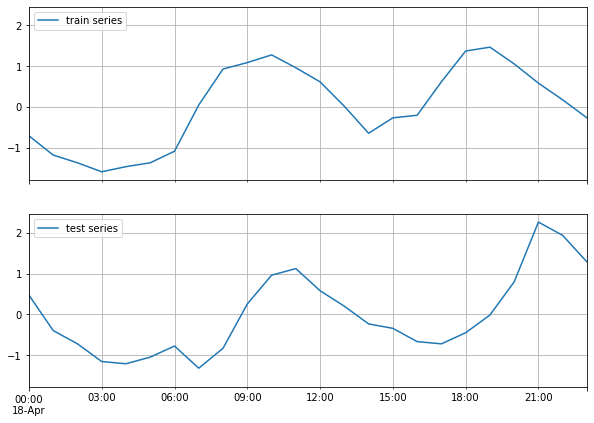

In [173]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt


test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].grid(which="both")
ax[1].legend(["test series"], loc="upper left")

plt.show()

`train_ds` and `test_ds` are now ready for `gluon-ts`